# **Default Payment Classification**

Name: Muhammad Fitri Amir bin Abdullah

Admin Number: P2222811

Class: DAAA/FT/2A/06
<hr>

## **Background Information:**
> A payment default usually happens after multiple payments on a loan or other debt are missed. The default happens when the lender decides to cut their losses. It also can be caused by spending over your credit limit, which forces your account into a default so that the lender can cut their losses.

Following this, I have to make a few assumptions:

- The bills and pays are on consecutive months
- The bills do not accumulate, and are individually calculated.

And based on the background context I gave in the first line, we can also conclude that people who spend more than their credit limit will be forced into a default.

In this task, I aim to predict customers of a bank who will have default payment using features such as:
- gender, 
- education, 
- credit limit<br> 
- payment history


## Importing Datasets/Libraries

In [254]:
#Importing the libraries and the dataset

# Basic libs
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

df = pd.read_csv('../ST1511 AIML-CA1-datasets/credit_dataset.csv')

## **Exploratory Data Analysis**

In this section, I will analyze the data to understand its characteristics, identify patterns, and gain insights into the data

In [255]:
#check data loaded

df.head()

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0


In [256]:
print(df.shape)
print(df.info())

df.isnull().sum()

df.nunique().sort_values()

(1600, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage:

Gender                           2
Marriage Status                  2
Default payment next month       2
Education                        3
Age                             48
Credit Limit                    60
Pay_Amount3                    751
Pay_Amount2                    789
Pay_Amount1                    805
Bill_Amount3                  1373
Bill_Amount2                  1401
Bill_Amount1                  1440
Customer ID                   1600
dtype: int64

> As we can see, there are no null values in the datas given, and majority of the variables are integers, with gender,education and marriage status as objects. Furthermore, by using sort values, we can see that every feature has > 1 unique value, which means that I do not need to drop any other features.

## **Visualisation**

In this section, I will visualise the data given,through methods such as univariate and bivariate graphs.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_40408\4249966827.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = corr_df.corr()


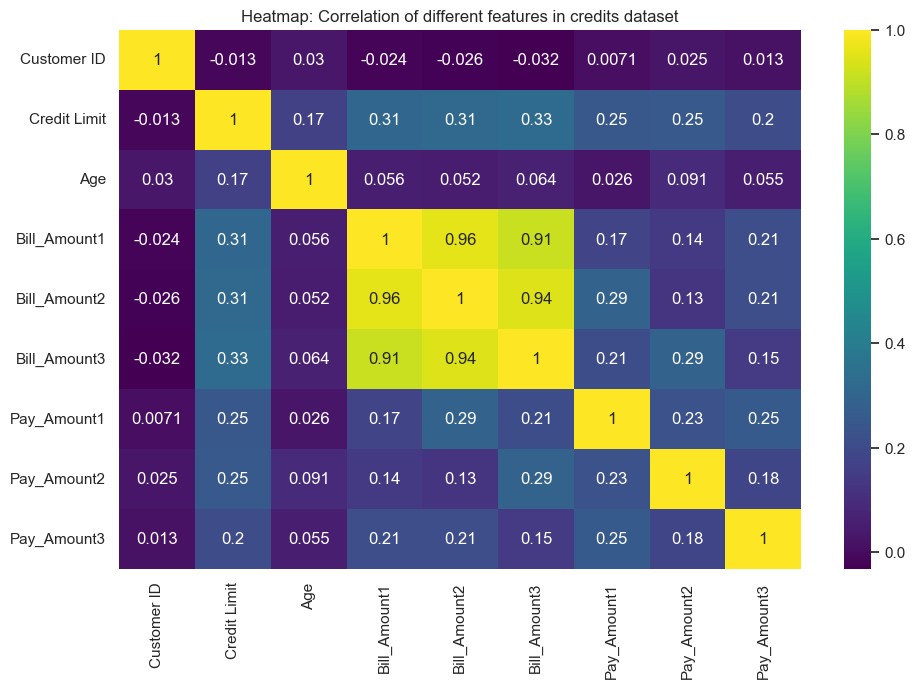

In [257]:

#Using seaborn to visualise the correlations in a heatmap
sns.set(rc={'figure.figsize':(11,7)})
corr_df = df.drop(['Default payment next month'], axis=1)

correlation = corr_df.corr()
sns.heatmap(correlation, cmap='viridis', annot=True)

#Using matplotlib to produce the plots
plt.title("Heatmap: Correlation of different features in credits dataset")
plt.show()

<font size = 4>

As we can see from the heatmap, all of the bill amounts have similar correlation to the other variables, hence I can combine the different bill amounts into 1 column and the pay amounts to 1 column respectively.

Originally, I wanted to try and combine all of the bill amounts, however after further thinking I realised that the bill amounts do not accumulate and every bill amount is the remaining bill at the end of each month. Hence, this means that Bill_Amount3 is the final remaining bill.

In [258]:
df["Total_paid"] = ""
df['Total_paid'] = df['Pay_Amount1'] + df['Pay_Amount2'] + df['Pay_Amount3']

df.head()

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_paid
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1,689
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1,2000
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0,4018
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0,5219
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0,48681


<font size = 4>

Next, I did a bivariate analysis on the different features to see the distribution of the features against the condition of default payment. This is to see whether there are any patterns beforehand.

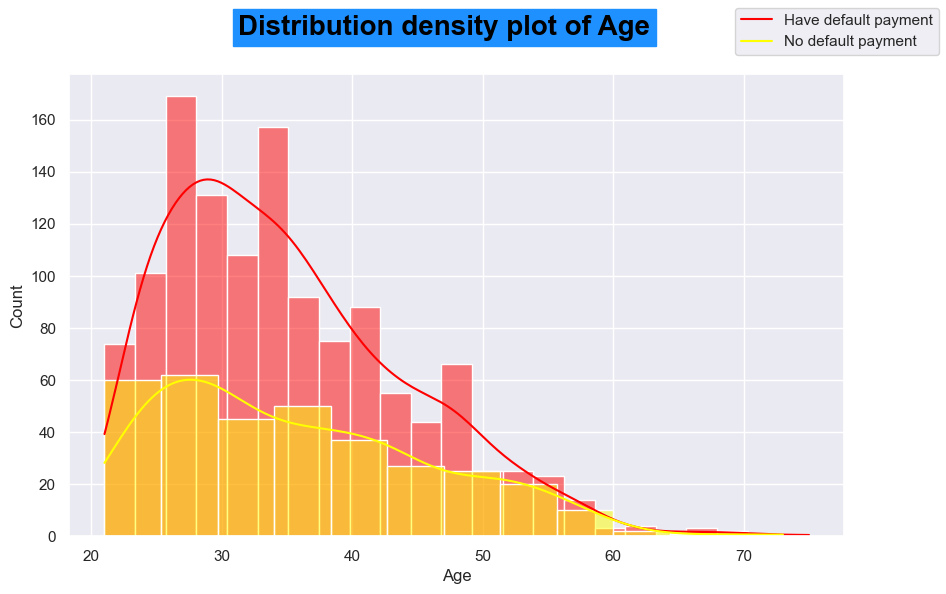

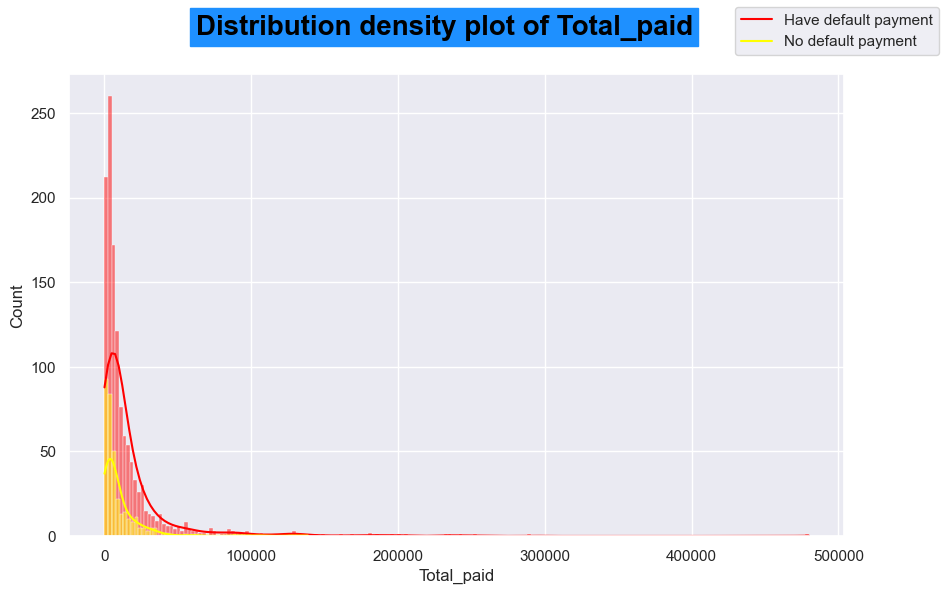

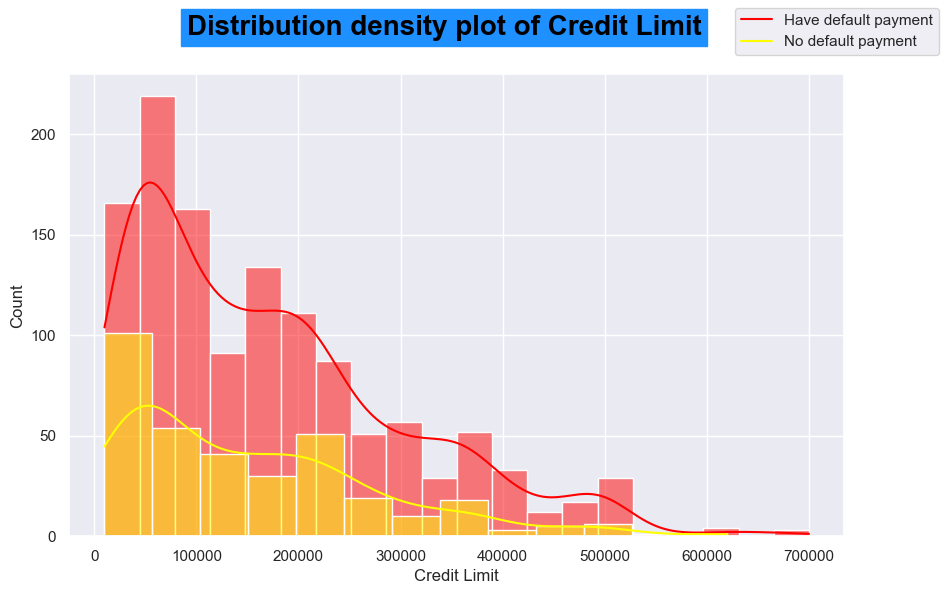

In [259]:
df_pay= df[df['Default payment next month']==0]
df_nopay = df[df['Default payment next month']==1]

features = ['Age', 'Total_paid','Credit Limit']

for feature in features:
  fig = plt.figure(figsize=(10,6))
  sns.histplot(data=df_pay, x=feature, kde=True, color='red', alpha=0.5)
  sns.histplot(data=df_nopay, x=feature, kde=True, color='yellow', alpha=0.5)

  fig.suptitle(f'Distribution density plot of {feature}',color='black',weight='bold',size=20, backgroundcolor= 'Dodgerblue')

  fig.legend(labels=['Have default payment','No default payment'])
  plt.show()

## **Feature engineering**

Firstly, I feel that Customer ID will not play a big part in classifying the data as it is just a unique identifier, therefore I will drop the column and I'll correct the typo made in the dataset (from univeresity to university) so that I won't make a mistake in my later codes

In [260]:
df = df.drop(['Customer ID'], axis = 1)
df['Education'] = df['Education'].replace(['univeresity'], 'university')

df.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_paid
0,20000,female,university,married,24,3913,3102,689,0,689,0,1,689
1,120000,female,university,single,26,2682,1725,2682,0,1000,1000,1,2000
2,90000,female,university,single,34,29239,14027,13559,1518,1500,1000,0,4018
3,50000,female,university,married,37,46990,48233,49291,2000,2019,1200,0,5219
4,50000,male,university,married,57,8617,5670,35835,2000,36681,10000,0,48681


## **Data Preprocessing** 
> In this section, I will engineer the features. 

As we can see, `Gender`, `Education` and `Marriage Status` have categorical data. To use this data, I will have to encode it using 1 of 4 methods:

- pd.get_dummies()
- One Hot Encoder
- Label Encoder
- Ordinal Encoder

Firstly, `Gender` and `Marriage Status` are not ordinal, therefore I will have to use One Hot Encoder while `Education` is ordinal, which means I will use Ordinal/Label Encoder.

In [261]:
#Finding out the unique values in all the variables with categorical data.

a = df['Gender'].unique()
b = df['Education'].unique()
c = df['Marriage Status'].unique()

print(a,b,c)

#One hot encoder for gender as it is not ordinal
labelencoder = LabelEncoder()

# encode the 'Gender' column
df['Gender'] = labelencoder.fit_transform(df['Gender'])
df['Marriage Status'] = labelencoder.fit_transform(df['Marriage Status'])

df.head()

['female' 'male'] ['university' 'post-graduate' 'high school'] ['married' 'single']


,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_paid
0,20000,0,university,0,24,3913,3102,689,0,689,0,1,689
1,120000,0,university,1,26,2682,1725,2682,0,1000,1000,1,2000
2,90000,0,university,1,34,29239,14027,13559,1518,1500,1000,0,4018
3,50000,0,university,0,37,46990,48233,49291,2000,2019,1200,0,5219
4,50000,1,university,0,57,8617,5670,35835,2000,36681,10000,0,48681


In [262]:
#Lastly, ordinal encoder for education as it is ordinal

from sklearn.preprocessing import OrdinalEncoder

# create an instance of the OrdinalEncoder class
encoder = OrdinalEncoder(categories=[['high school', 'university', 'post-graduate']])

# fit and transform the 'Education' column
df['Education'] = encoder.fit_transform(df[['Education']])

df.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_paid
0,20000,0,1.0,0,24,3913,3102,689,0,689,0,1,689
1,120000,0,1.0,1,26,2682,1725,2682,0,1000,1000,1,2000
2,90000,0,1.0,1,34,29239,14027,13559,1518,1500,1000,0,4018
3,50000,0,1.0,0,37,46990,48233,49291,2000,2019,1200,0,5219
4,50000,1,1.0,0,57,8617,5670,35835,2000,36681,10000,0,48681


In [263]:
df.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_paid
0,20000,0,1.0,0,24,3913,3102,689,0,689,0,1,689
1,120000,0,1.0,1,26,2682,1725,2682,0,1000,1000,1,2000
2,90000,0,1.0,1,34,29239,14027,13559,1518,1500,1000,0,4018
3,50000,0,1.0,0,37,46990,48233,49291,2000,2019,1200,0,5219
4,50000,1,1.0,0,57,8617,5670,35835,2000,36681,10000,0,48681


<font size = 4>
Take note that in Education, 0 is high school, 1 is university and 2 is post graduate. In gender, 0 is female while 1 is male and in Marriage Status 0 is married while 1 is single.<br>

Now that we have done our encoding, we can move on to our exploratory data analysis.

<font size = 4>
In this task, I feel that the False Positives are the most important to avoid as it may force customers to make default payment even though they may not need to. With that context set, I will list out a few ways of determining the results produced by the model.<br>

Since our feature space is not extremely large, we can afford to plot out a Pairplot to visualise the distribution of data points with relation to Target variable Default Payment

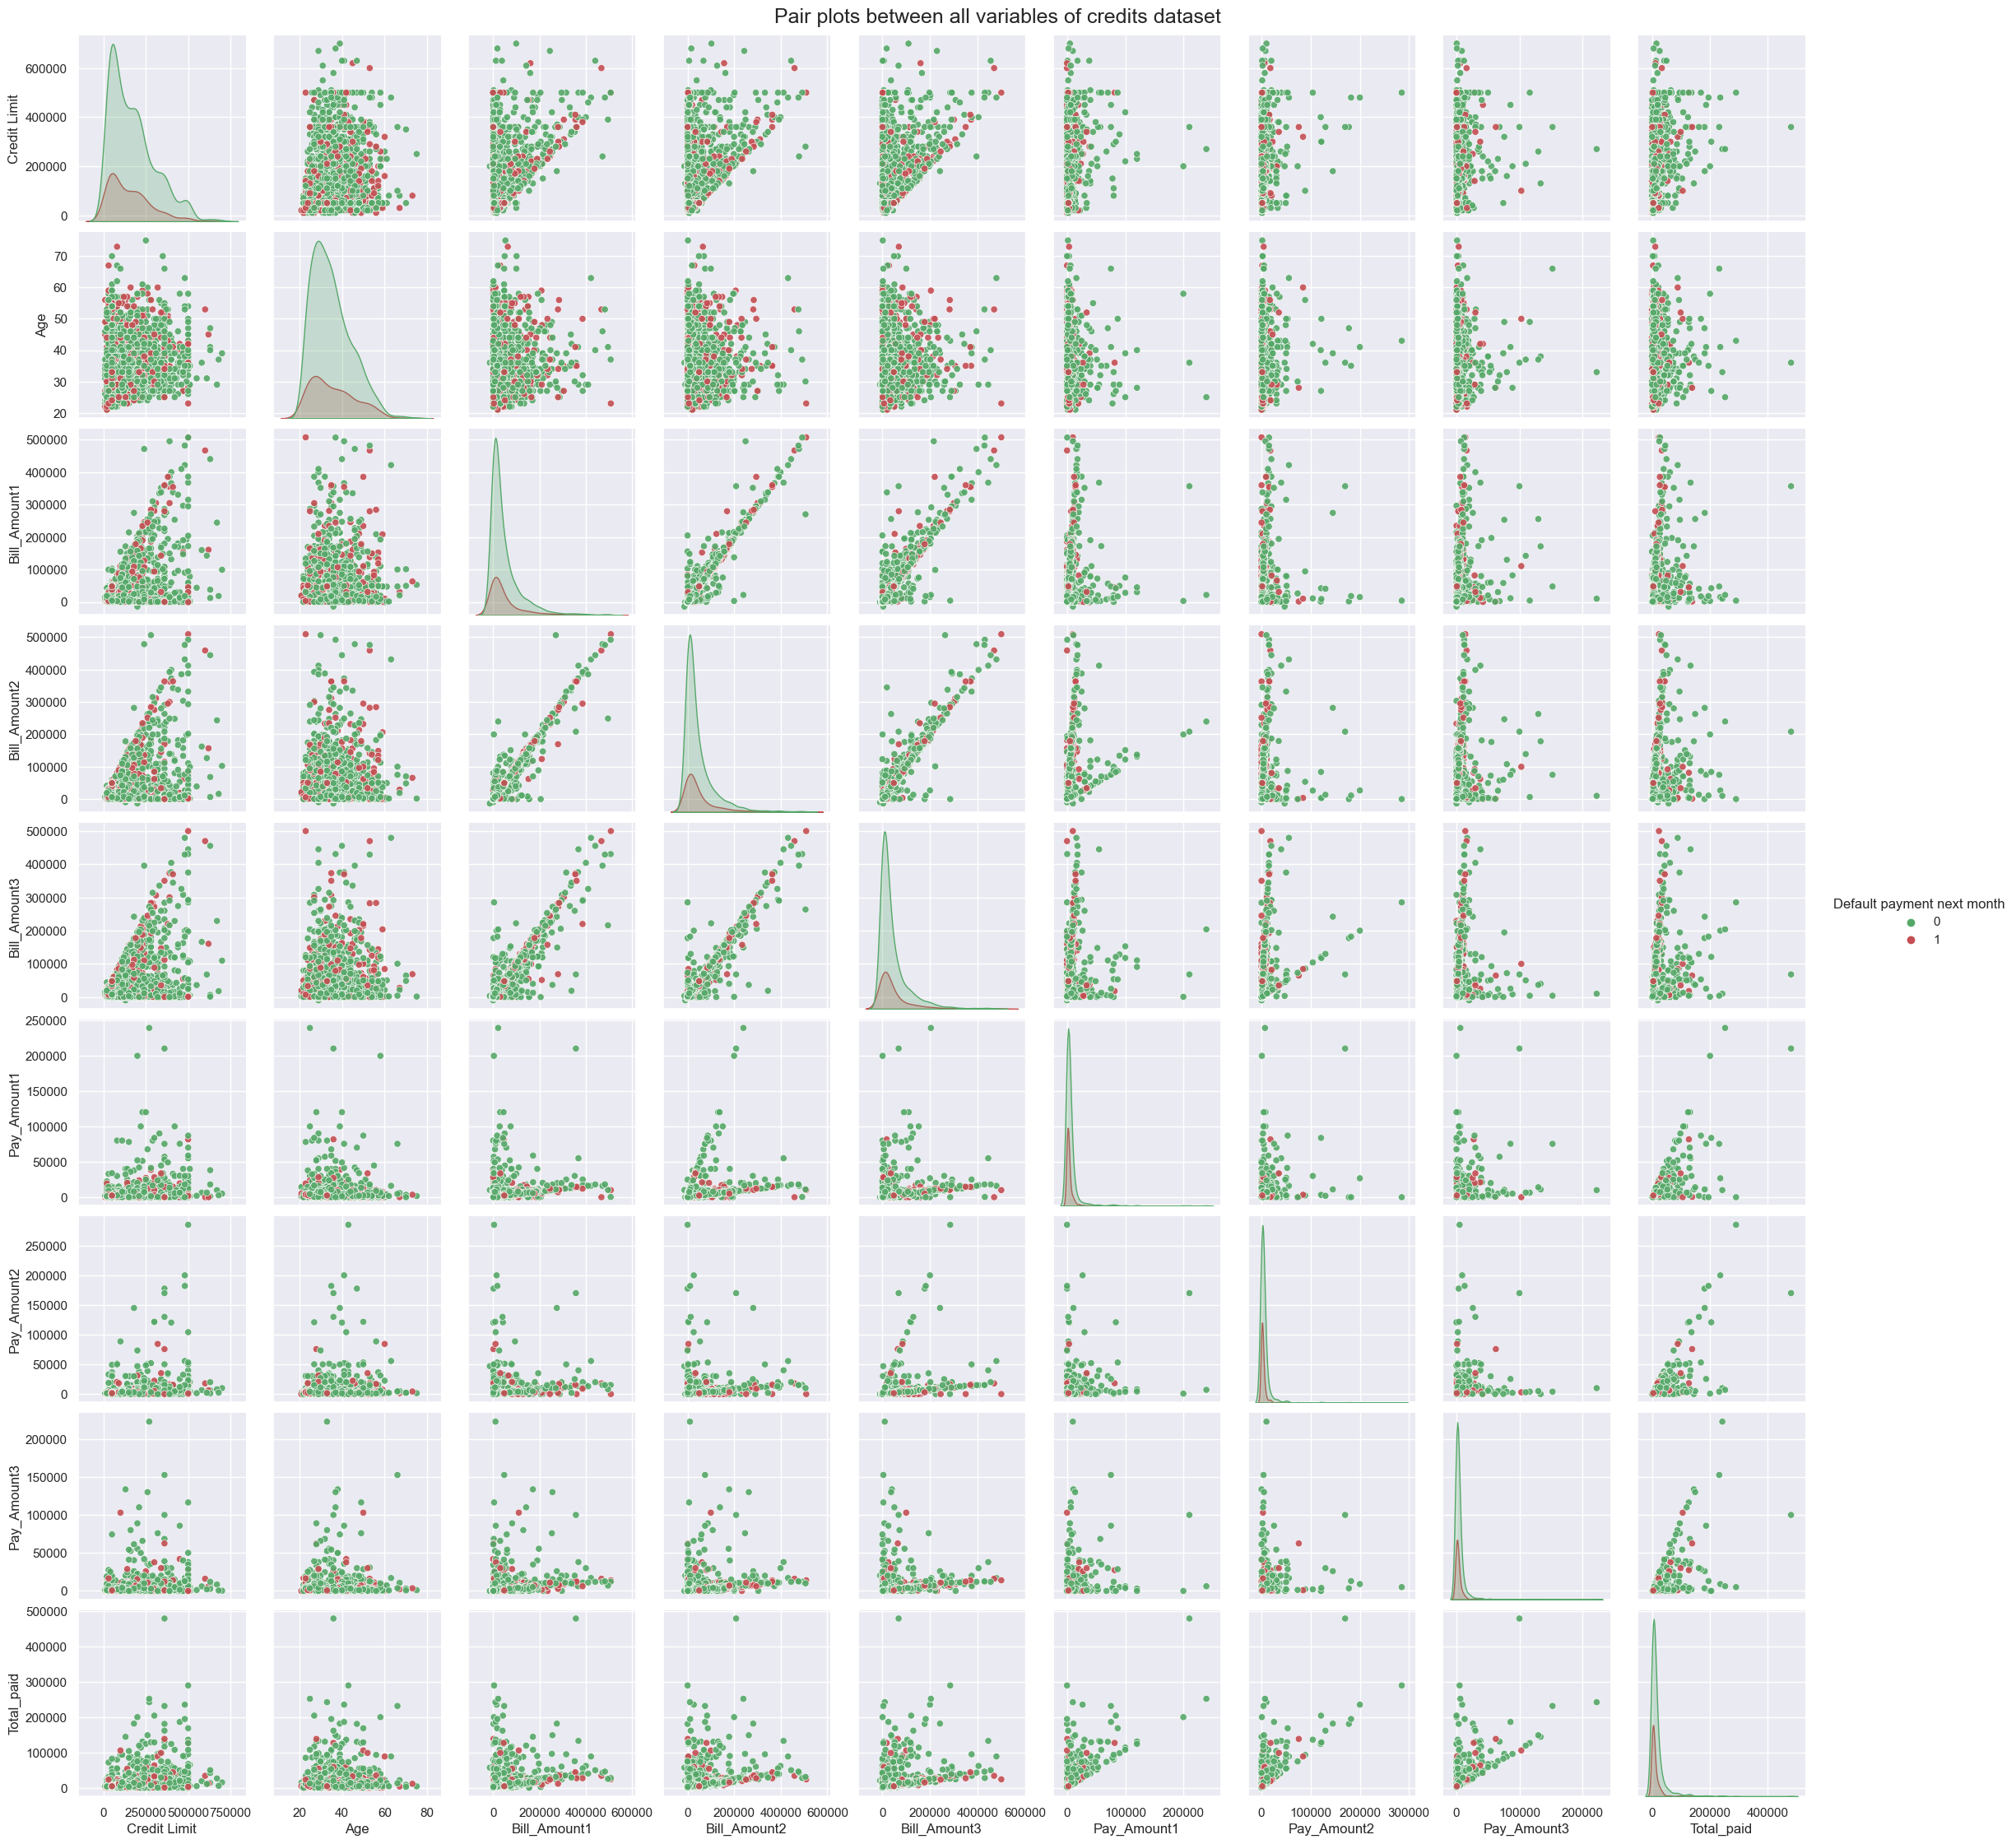

In [264]:
df_nom = df.drop(['Gender','Education','Marriage Status'], axis=1)

g = sns.pairplot(
    df_nom,
    hue="Default payment next month",
    palette=["g", "r"],
    plot_kws=dict(alpha=0.9),
)
g.fig.suptitle("Pair plots between all variables of credits dataset", y=1.001, fontsize=18)
plt.show()

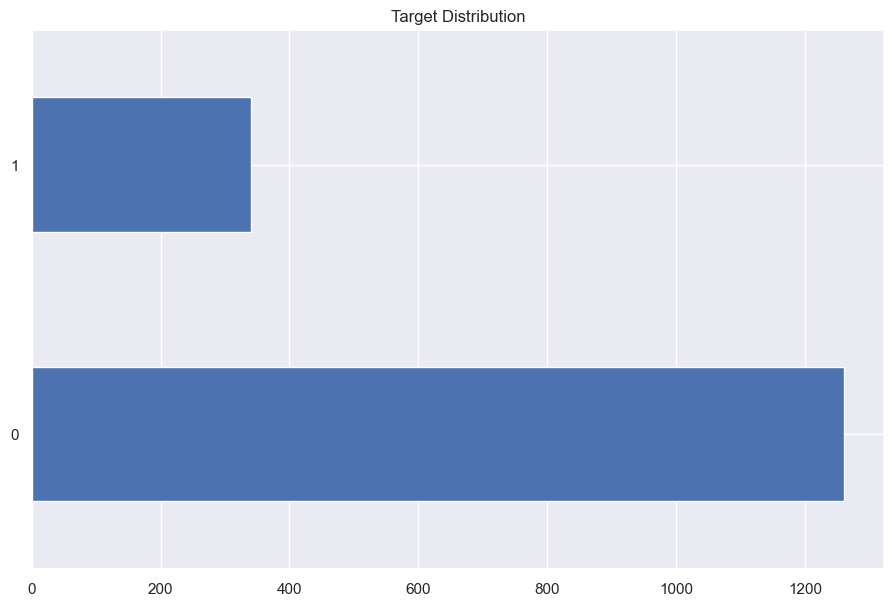

In [265]:
ax = (
    df["Default payment next month"].value_counts().plot(kind="barh", title="Target Distribution")
)

<font size = 4>

Before I split my data, I feel that I should oversample my data to equal out the minority to the majority data points. To do that, I will need to first standardise the data as the oversampling techniques that I would like to apply use concepts of kNN, which requires me to normalise my data beforehand.

In [266]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,MinMaxScaler,Normalizer

# Select the continuous columns to be standardized
continuous_cols = ['Credit Limit', 'Age', 'Total_paid','Bill_Amount1',	'Bill_Amount2',	'Bill_Amount3',	'Pay_Amount1',	'Pay_Amount2',	'Pay_Amount3']

# Create a Normalizer object
scaler = MaxAbsScaler()

# Standardize the selected columns
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

df.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_paid
0,0.028571,0,1.0,0,0.320000,0.007707,0.006092,0.001378,0.000000,0.002416,0.000000,1,0.001435
1,0.171429,0,1.0,1,0.346667,0.005282,0.003387,0.005365,0.000000,0.003507,0.004489,1,0.004167
2,0.128571,0,1.0,1,0.453333,0.057588,0.027546,0.027121,0.006349,0.005261,0.004489,0,0.008371
3,0.071429,0,1.0,0,0.493333,0.092550,0.094718,0.098595,0.008365,0.007081,0.005387,0,0.010873
4,0.071429,1,1.0,0,0.760000,0.016972,0.011134,0.071679,0.008365,0.128643,0.044893,0,0.101419


In [267]:
main_df = df.drop(['Default payment next month'], axis = 1)
target_df = df['Default payment next month']

X_train, X_test, y_train, y_test = train_test_split(main_df, target_df, test_size=0.2, random_state=42, stratify= target_df) # stratify so that percentage of samples are presered

#Show the percentages of trained/tested data that are 0s
print(f"Percentage of label '0' in Training data: {(len(y_train[y_train == 0]) / len(y_train)) * 100}%")
print(f"Percentage of label '0' in Test data: {(len(y_test[y_test == 0]) / len(y_test)) * 100}%")

Percentage of label '0' in Training data: 78.75%
Percentage of label '0' in Test data: 78.75%


<font size = 4>

To continue more about ADASYN, the way it works is that for each of the minority observations it first finds the impurity (the amount of majority data points) of the neighborhood, by taking the ratio of majority observations in the neighborhood and k (the minority points). This is an oversampling method, which means that the amount of minority datapoints will increase in order to match the amount of majority data points.

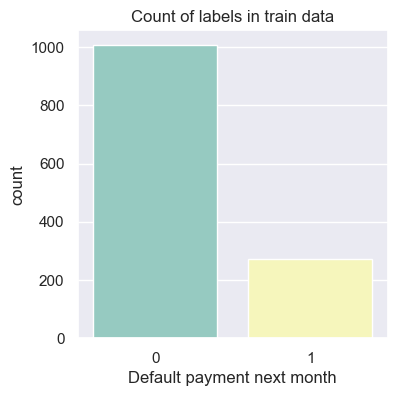

In [268]:
#countplot to compare the count of both machine status in the dataset
sns.set(rc={'figure.figsize':(4,4)})
ax = sns.countplot(x = y_train, data=df, palette="Set3")
plt.title('Count of labels in train data')
plt.show()

List of all the possible evalutation Metrics:

- Accuracy
>Percent of correct predictions

- Precision
>Ability to find only relevant samples (not label a negative as a positive)

- Recall
>Ability to find all positive samples

- 'f1-score'
>Harmonic mean of precision and recall

- 'fβ-score'
>Same as f1-score but able to assign different weights to prescision and recall

'roc_auc'
>Area under the receiver operator characteristic curve

In [269]:
# Select the top 10 best features
selector = SelectKBest(f_classif, k=10)

# Fit the selector on the training data and transform both training and test data
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the selected feature names
selected_feature_names = X_train.columns[selector.get_support()]

# Print the selected feature names
print("Selected features:", list(selected_feature_names))
X_train_final = X_train.drop(X_train.columns[~selector.get_support()], axis=1)
X_test_final = X_test.drop(X_test.columns[~selector.get_support()], axis=1)

# Print the selected feature names
print("Selected features:", list(X_train_final.columns))

Selected features: ['Credit Limit', 'Education', 'Marriage Status', 'Age', 'Bill_Amount2', 'Bill_Amount3', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3', 'Total_paid']
Selected features: ['Credit Limit', 'Education', 'Marriage Status', 'Age', 'Bill_Amount2', 'Bill_Amount3', 'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3', 'Total_paid']


In [270]:
X_train_final.head()

,Credit Limit,Education,Marriage Status,Age,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Total_paid
924,0.042857,1.0,1,0.320000,0.055794,0.057157,0.007390,0.005962,0.004534,0.009327
423,0.285714,1.0,0,0.506667,0.208009,0.205352,0.018820,0.000000,0.015713,0.016667
611,0.514286,2.0,1,0.386667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
960,0.542857,2.0,1,0.573333,0.015478,-0.000004,0.000163,0.000000,0.000000,0.000081
985,0.185714,0.0,1,0.573333,0.012523,-0.000004,0.026905,0.000007,0.004207,0.015358


## **Baseline Model**

In [271]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

models = [
    ("KNN", KNeighborsClassifier()), 
    ("LogReg", LogisticRegression()), 
    ("DecisionTree", DecisionTreeClassifier()), 
    ("RandomForest", RandomForestClassifier()), 
    ("GradientBoost", GradientBoostingClassifier()),
    ('Ridge', RidgeClassifier()),
    ('SGD', SGDClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('GaussianNB', GaussianNB()),
    ('Extra Trees', ExtraTreesClassifier())
]

scores = []

for name, model in models:
    model.fit(X_train, y_train)
    cv_score = cross_validate(model, X_train_final, y_train, scoring=scoring_metrics , cv=cv, n_jobs=2, return_train_score=True)
    score_df = pd.DataFrame(cv_score)
    mean_scores = score_df.mean().rename(name)
    scores.append(mean_scores)

score_df = pd.concat(scores, axis=1).T

# score_df

score_df.sort_values(by=['test_recall', 'train_recall', 'test_f1', 'train_f1'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
GaussianNB,0.002009,0.008380,0.328906,0.339062,0.215246,0.236545,0.886279,0.927635,0.345999,0.376866,0.552544,0.587137
DecisionTree,0.011169,0.011171,0.684375,1.000000,0.237416,1.000000,0.266713,1.000000,0.249453,1.000000,0.528264,1.000000
RandomForest,0.373225,0.032914,0.785937,1.000000,0.424809,1.000000,0.122921,1.000000,0.186438,1.000000,0.582531,1.000000
GradientBoost,0.313563,0.007979,0.774219,0.867383,0.300635,0.971800,0.092163,0.396497,0.138727,0.562300,0.576403,0.946929
KNN,0.003598,0.018547,0.754687,0.800977,0.217302,0.610038,0.089000,0.212177,0.125237,0.314689,0.519172,0.799500
Extra Trees,0.200524,0.039520,0.775781,1.000000,0.288254,1.000000,0.062605,1.000000,0.101258,1.000000,0.546221,1.000000
AdaBoost,0.123256,0.024135,0.778125,0.799609,0.256392,0.653921,0.055328,0.149490,0.090506,0.242977,0.611107,0.809546
SGD,0.010473,0.010372,0.797656,0.783594,0.050000,0.054545,0.003509,0.002791,0.006557,0.005310,0.559589,0.591168
LogReg,0.016357,0.010172,0.799219,0.784570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562617,0.592755
Ridge,0.006781,0.008976,0.799219,0.784570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562135,0.597594


Baseline Accuracy Score: 0.7879
Baseline Precision Score: 0.0000
Baseline Recall Score: 0.0000
Baseline F1 Score: 0.0000
Baseline Roc_auc Score: 0.5000
Baseline Accuracy Score :0.7875


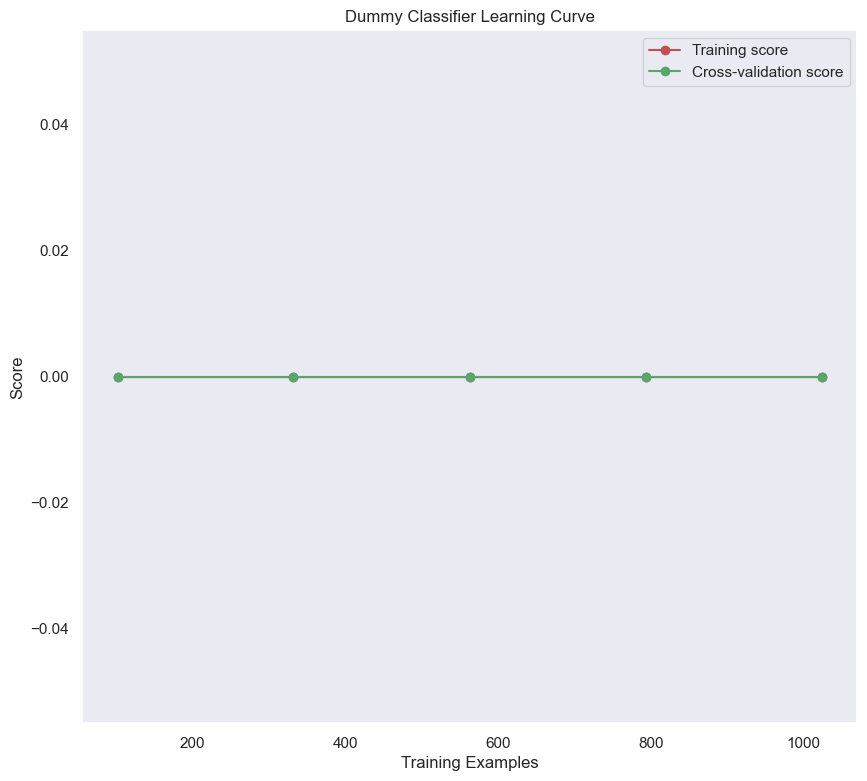

In [277]:
scoring_metrics = ['accuracy','precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
dummy = DummyClassifier()

cv_score = cross_validate(DummyClassifier(), X_train_final, y_train, scoring= scoring_metrics , cv=cv, n_jobs=2, return_train_score=True)

for metric in scoring_metrics:
    print("Baseline {} Score: {:.4f}".format(metric.capitalize(), cv_score['train_'+metric].mean()))

dummy_clf = DummyClassifier(strategy = 'most_frequent', random_state=42)
dummy_clf.fit(X_train_final, y_train)

print("Baseline Accuracy Score :{:.4f}".format(dummy_clf.score(X_test, y_test)))

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(dummy_clf, X_train_final, y_train, cv=5, n_jobs=2, train_sizes=np.linspace(0.1, 1, 5), scoring='recall')

plt.rcParams['figure.figsize'] = [10, 9]

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()

plt.title("Dummy Classifier Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")


plt.rcParams["figure.figsize"] = (20,3)
plt.show()

Baseline Accuracy Score: 0.4949
Baseline Precision Score: 0.2115
Baseline Recall Score: 0.5066
Baseline F1 Score: 0.2984
Baseline Roc_auc Score: 0.5000
Baseline Accuracy Score: 0.4719
Baseline Precision Score: 0.1824
Baseline Recall Score: 0.4265
Baseline F1 Score: 0.2555
Baseline Roc_auc Score: 0.4553


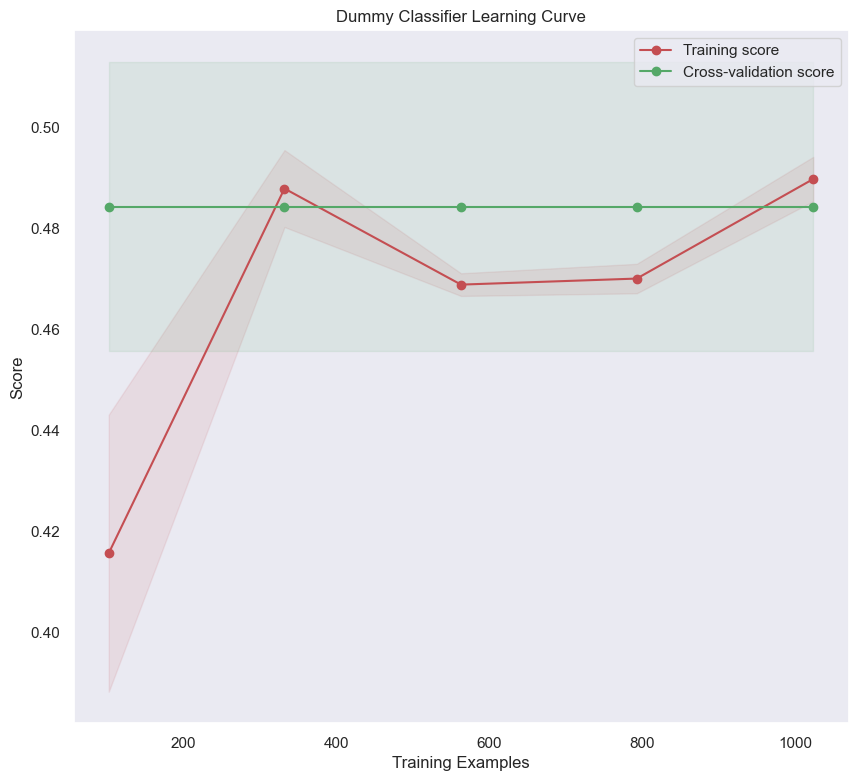

In [273]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Compute cross-validated scores for all metrics
dummy = DummyClassifier(strategy='uniform', random_state=42)
cv_scores = cross_validate(dummy, X_train, y_train, scoring = scoring_metrics, cv=cv, return_train_score=True)

# Print out cross-validated scores
for metric in scoring_metrics:
    print("Baseline {} Score: {:.4f}".format(metric.capitalize(), cv_scores['train_'+metric].mean()))

# Fit and score dummy classifier on test set
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print("Baseline Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Baseline Precision Score: {:.4f}".format(precision_score(y_test, y_pred)))
print("Baseline Recall Score: {:.4f}".format(recall_score(y_test, y_pred)))
print("Baseline F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("Baseline Roc_auc Score: {:.4f}".format(roc_auc_score(y_test, y_pred)))

# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(DummyClassifier(strategy='uniform', random_state=42), X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 5), scoring='accuracy')

plt.rcParams['figure.figsize'] = [10, 9]

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()

plt.title("Dummy Classifier Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")

plt.rcParams["figure.figsize"] = (20, 3)
plt.show()

In [274]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Compute cross-validated scores for all metrics
dummy = DummyClassifier(strategy='uniform', random_state=42)
cv_scores = cross_validate(dummy, X_train, y_train, scoring = scoring_metrics, cv=cv, n_jobs=-1)

# Print out cross-validated scores
for metric in scoring_metrics:
    print("Baseline {} Scotre: {:.4f}".format(metric.capitalize(), cv_scores['train_'+metric].mean()))

# Fit and score dummy classifier on test set
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)

train_sizes, train_scores, test_scores = learning_curve(dummy_clf, X_train, y_train, cv=5, n_jobs=2, train_sizes=np.linspace(0.1, 1, 5), scoring='accuracy')

plt.rcParams['figure.figsize'] = [10, 9]

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()

plt.title("Dummy Classifier Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")

plt.show()

KeyError: 'train_accuracy'

Finally, I will display the results and distribution of the guesses of my machine through a Confusion Matrix. This is what the confusion matrix represents.

<img src="DefaultConfusionMatrix.png">

Confusion Matrix:
[[252   0]
 [ 68   0]]


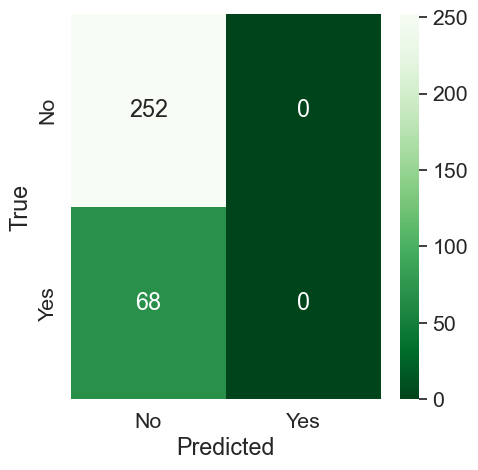

In [298]:
# Predict labels on the test set
y_pred = dummy_clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.set(font_scale=1.4) # Adjust to fit the plot
sns.heatmap(cm, annot=True, cmap='Greens_r', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.rcParams["figure.figsize"] = (5, 5)
plt.show()

In [ ]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train, y_train)

dummy_clf.score(X_test, y_test)

0.471875

## **Model Selection**

To decide what model to use, we must first look at the different categories of models; ensemble and classical.

Ensemble models are generally better as they are a combination of different models. These different models are joined together to overcome their individual weakness

<font size = 4>
As we can see, the data is unbalanced. There are a lot more customers who do not need to pay default payments than those who need to pay. There are 2 main ways to solve this imbalance, one being undersampling and the other being oversampling. I feel that undersampling will cause a loss in important details hence I will avoid undersampling. Therefore, ue to this major imbalance, we will need to  find out a way in order to generate synthetic samples for the minority class, in this case customers required to pay default payment. <br><br>
To do that, we will use either Adaptive Synthetic Sampling Approach(ADASYN) or Synthetic Minority Oversampling Technique (SMOTE). In this task, I would prefer ADASYN as SMOTE adds too much noisy data points ie useless data, and also generates instances that are in the same direction, which complicates the decision surface made by a few classifier algorithms. Another way going about this problem is random oversampling. I feel that ADASYN is better than random oversampling as random oversampling duplicates existing minority class samples to balance the dataset. On the other hand, ADASYN generates new synthetic samples that are closer to the decision boundary, thereby addressing the issue of over-fitting.



SMOTE:<br>

<img src="SMOTE Example.png">

ADASYN:<br>



and if you need cats to visualise it:<br>
<img src="adasynvsmote.jpg">

In [ ]:
# counter = Counter(y_train)

# print('Before', counter)

# '''
# By setting the random_state parameter to a fixed value,the algorithm generates the same synthetic samples 
# each time it is run, which can make the results more reproducible
# '''
# ada = ADASYN(random_state = 42)
# X_train, y_train = ADASYN().fit_resample(X_train, y_train)

# # smote = SMOTE(random_state = 42)
# # X_train, y_train = SMOTE().fit_resample(X_train, y_train)


# counter = Counter(y_train)

# print('After', counter)

# print(f"Percentage of label '0' in Training data: {(len(y_train[y_train == 0]) / len(y_train)) * 100}%")


<hr>

## References:

https://gocardless.com/guides/posts/payment-defaults/ <br>
https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/<br>
https://medium.com/mlearning-ai/what-the-heck-is-random-state-24a7a8389f3d#<br>
https://www.kaggle.com/code/residentmario/oversampling-with-smote-and-adasyn
https://thepointsguy.com/guide/over-credit-limit/ <br>